# Decision Trees

_Decision trees_ are versatile machine learning algorithms that can perform both classification and regression tasks, and even multi-output tasks. They are capable of fitting complex datasets. Decision trees are the fundamental component of _random forests_ which are among the most powerful machine learning algorithms available today. In this notebook we'll learn how to train, visualize, and make predictions with decision trees, and explore some of their limitations as well. 

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Training and Visualizing a Decision Tree

The following code trains a DecisionTreeClassifier on the iris dataset.

In [4]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42) # changing max_depth and random_state produce different trees
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

We'll create a graph visualization using the _export_graphviz()_ function of SciKit-Learn's Tree library to output a graph visualization file called _iris_tree.dot_ and then load it so we can see it in the notebook.

Scikit-Learn uses the CART (Classification and Regreesion Tree) algorithm, which produces only _binary trees_: any node with children will have exactly two children. (In other words, the questions asked at each step only have yes/no or true/false answers). There are other algorithms, such as ID3, that can produce decision trees with nodes that have more than two children. The CART algorithm works by splitting the training set into two subsets using a single feature _k_ and a threshold _t_ (in this example, "petal length <= 2.45 cm"). How does it choose k and t? It searches for the pair that produces the purest subsets, weighted by their size. This is a cost-minimization function, just like the error-minimization functions we have seen before. Specifically, it tries to minimize the value of the Gini coefficients of the left and right subsets, while weighting each subset by its size. (See https://www.geeksforgeeks.org/cart-classification-and-regression-tree-in-machine-learning/ for more about how it works.) Once the algorithm has split the training set in two, it splits the subsets using the same logic, until it reaches the maximum depth (a hyperparameter) or if it cannot find a split that would reduce the impurity any further. There are additional hyperparameters that allow you to control additional stopping conditions. 

The CART algorithm is a so-called _greedy_ algorithm: It searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether the split at a higher level will lead to the lowest possible splits several levels down. A greedy algorithm often produces solutions that are reasonably good, but not guaranteed to be optimal. Unfortunately, finding the optimal series of splits is known to be an _NP-Complete_ problem. It requires an exponential amount of time that increases with the number of splits. This is why we settle for the "reasonably good" solution instead of trying to find the optimal solution.

In [5]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str("iris_tree.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

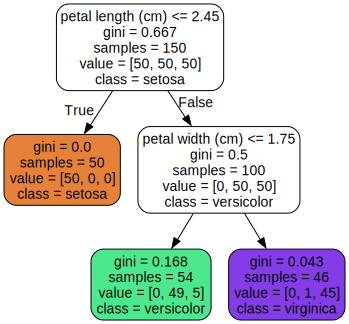

In [6]:
from graphviz import Source

Source.from_file("iris_tree.dot")

# Making Predictions

Let's see how the above decision tree makes predictions. Suppose you find an iris flower and you want to classify it based on its petals. You start at the _root node_ (depth 0, at the top). This node asks whether the flower's petal length is less than or equal to than 2.45 cm. If it is, you move down to the left (True); if it isn't, you move down to the right (False). The left-hand path (colored orange) is a _leaf node_ (it does not ask any questions): the predicted class for that node is _iris setosa_. Had you gone to the right, the next node is not a leaf node: it asks whether the petal width is less than or equal to 1.75 cm. Again, you take the appropriate branch based on the answer, and arrive at a prediction of either _iris versicolor_ if the width is less than or equal to 1.75 cm or _iris virginica_ if the width was greater than 1.75 cm. (In either case, the length is greater than 2.45 cm, because that fact was established at the root node.)

A node's `samples` attribute counts how many training instances it applies to. In the above tree, there are 150 total samples (from the root node). Of those, 100 samples have a petal length greater than 2.45 cm; of those 100, 54 have a petal width less than or equal to 1.75 cm and the other 46 have a petal width greater than 1.75 cm. 

A node's `value` attribute tells you how many training instances of each class the value applies to (remember, we are training on labeled data, so we know the answers for our training instances). Remember from the SVM discussion that we allow for some outliers as opposed to requiring a hard boundary. So, the green box tells us that there are 0 _setosa_ values, 49 _versicolor_ values, and 5 _virginica_ values in the training data that would end up at this node.

Finally, the `gini` attribute (which you might have heard about in the context of economic inequality) measures its _Gini impurity_: a node is "pure" (gini=0) if all training instances it applies to belong to the same class. For example, since the orange node applies only to _setosa_ flowers (samples = 50; value = [50, 0 ,0] meaning no outliers) it has a gini value of 0. Since the green and purple boxes do have a few mispredictions, their gini values are not 0.

The next figure shows the decision tree's decision boundaries. The thick vertical line represents the decision boundary of the root node (depth 0, or the first split). This is set at petal length = 2.45 cm. Since the left-hand area is only filled with _iris setosa_ values it cannot be split any further. However, the right-hand area still has multiple classes in it, so the depth 1 right node splits it again, at petal width = 1.75 cm, represented by the dashed line. Since max_depth was set to 2, the algorithm stops there, but if we had set max_depth to 3, then the two depth-2 nodes would each get another decision boundary (represented by the vertical dotted lines). You can see what that tree would have looked like by going back up to cell (4), changing max_value from 2 to 3, and running the notebook again.

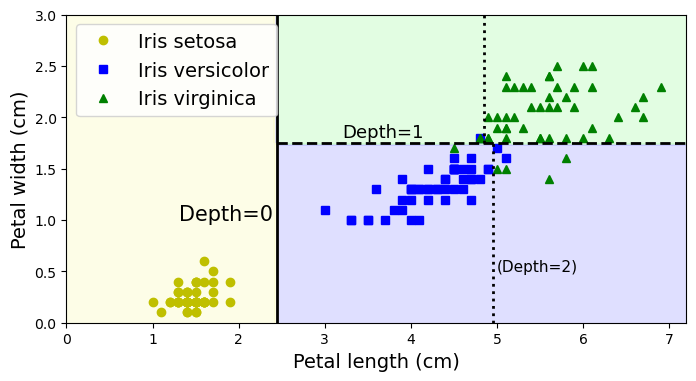

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

You can access the tree structure via the `tree_` attribute:

In [8]:
tree_clf.tree_

For more information, check out this class's documentation:

In [9]:
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

See the extra material section below for an example.

# Estimating Class Probabilities

A decision tree can also estimate the probability that an instance belongs to a particular class _k_. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class _k_ in this node. For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the decision tree outputs the following probabilities: 0% for _iris setosa_ (0/54), 90.7% for _iris versicolor_ (49/54), and 9.3% for _iris virginica_ (5/54). And if you ask it to predict the class, it outputs _iris versicolor_ (class 1) because it has the highest probability.

In [10]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [11]:
tree_clf.predict([[5, 1.5]])

array([1])

# Regularization Hyperparameters

Decision trees make very few assumptions about the training data (as opposed to linear classifiers, which assume that the data points are linearly separable, for example). If left unconstrained, the tree structure will adapt itself very tightly to the training data. In other words, these models are highly prone to overfitting. Such a model is often called _nonparametric_, not because it does not have any parameters, but because the number of parameters are not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a _parametric model_, such as the linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting). 

We can, of course, restrict the decision tree's freedom during training. This is called _regularization_. There are various hyperparameters available for our `DecisionTreeClassifier`, such as restricting the maximum depth of the decision tree, specifying the maximum number of features that are evaluated for splitting at each node, setting a maximum number of leaf nodes, specifying the minimum number of samples a node must have before it can be split, specifying the minimum number of samples a leaf node must have before it can be created, and more. Increasing _minimum_ hyperparameters or decreasing _maximum_ hyperparameters is _regularizing_ the model. (It's also possible to have an algorithm that trains the tree first without restrictions, then _prunes_ it by combining / deleting nodes.) 

Let's test regularization using something called the _moons_ dataset, which is just a toy dataset in which the data points are shaped as two interleaving crescent moons. The `make_moons()` function will generate such a data set. We'll train one decision tree without regularization, and another with `min_samples_leaf = 5`. The following figure shows the decision boundaries for each of these trees.

In [12]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

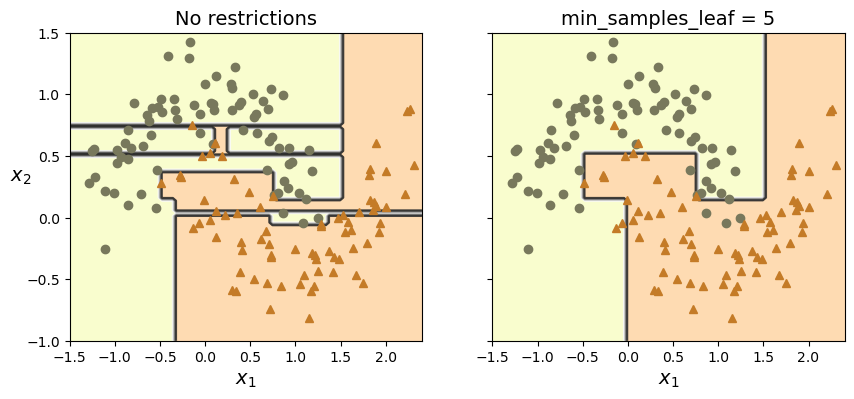

In [13]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")

plt.show()

The unregularized model on the left is clearly overfitting, while the regularized model on the right looks much better. We can verify this by evaluating both trees on a test set generated using a different random seed (43 instead of 42 if you haven't changed anything in this notebook yet).

In [14]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [15]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

# Regression

Decision trees are also capable of performing regression tasks. Let's build a regression tree using the `DecisionTreeRegressor` class, training it on a quadratic training set and setting `max_depth = 2`.

**Code example:**

In [16]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

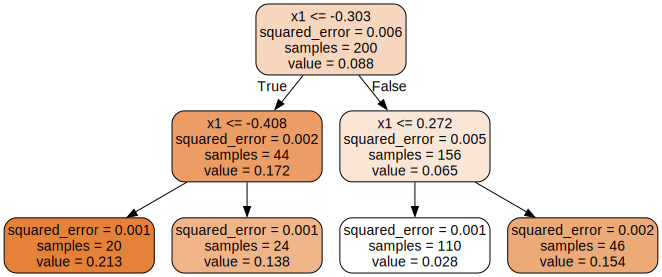

In [17]:
export_graphviz(
    tree_reg,
    out_file=str("regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file("regression_tree.dot")

This tree looks very similar to the classification tree we built earlier, but instead of predicting a class at each node, it predicts a value. We track the mean squared error at each node. For comparison purposes, let's also train a regressor with `max_depth = 3` and see the difference in the decision thresholds, then visualize each tree's predictions. The tree on the left has fewer splits, as we would expect. Notice how the predicted value for each region is always the average value of the instances in that region. The algorithm splits each region in such a way that makes most training instances as close as possible to that predicted value.

In [18]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [19]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [20]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

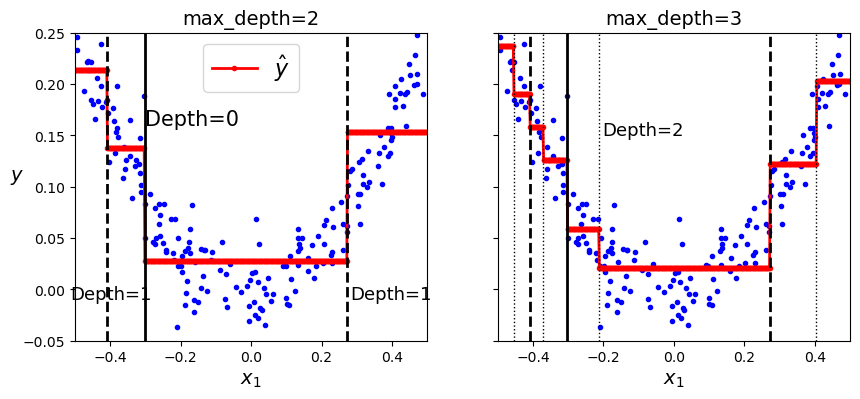

In [21]:
def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

plt.show()

Just like for classification tasks, decision trees are prone to overfitting when dealing with regression tasks. Without any regularizations (i.e., using the default hyperparameters) you get the predictions on the left in the figures below. These are obviously overfitting the training set very badly. Just setting `min_samples_leaf = 10` results in a much more reasonable model, seen on the right.

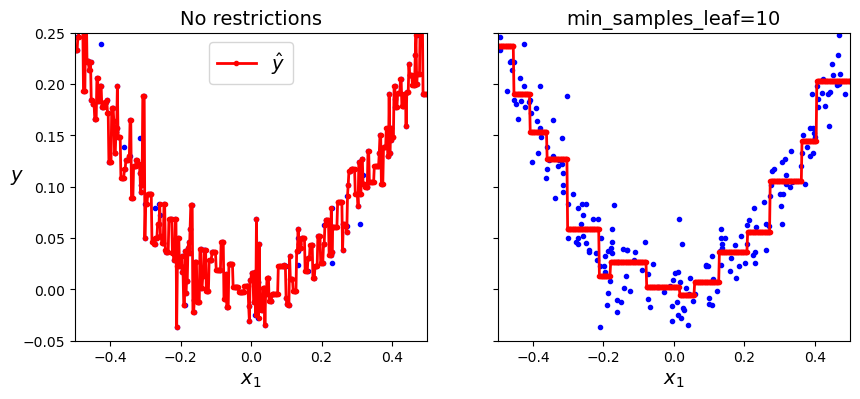

In [22]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

# Sensitivity to axis orientation

As you may have noticed, decision trees use orthogonal decision boundaries: that is, all splits are perpendicular to an axis. This makes them sensitive to the orientation of the data. Rotating the dataset also leads to completely different decision boundaries. The following figure shows a simple linearly separable dataset. On the left, a decision tree can split it easily, while on the right, after the data set has been rotated 45 degrees, the decision boundary looks convoluted. Although both trees fit the data set, the model on the right is less likely to generalize well. 

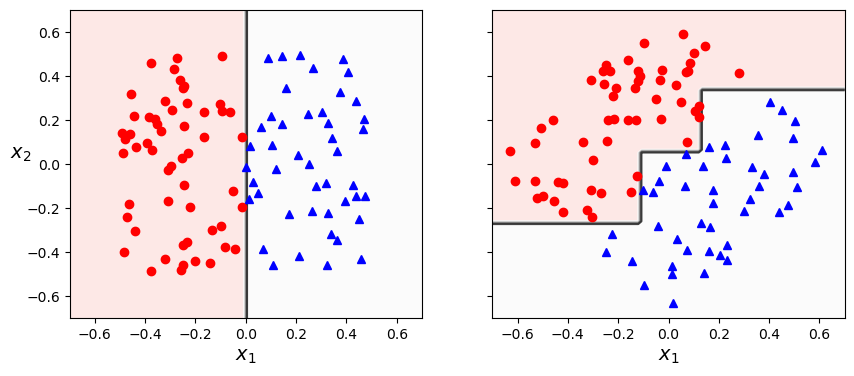

In [23]:
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

plt.show()

One way to limit this problem is to scale the data, then apply a _Principal Component Analysis_ transformation. PCA rotates the data in such a way that reduces the correlation between the features, which often (though not always) makes things easier for trees. Let's create a small pipeline that scales the data and rotates it using PCA, then train a `DecisionTreeClassifier` on that data. The next figure shows the decision boundaries of that tree: as you can see, the rotation makes it possible to fit the dataset pretty well using only one feature, which is a linear function of both the petal length and width, instead of treating length and width as separate axes.

In [24]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

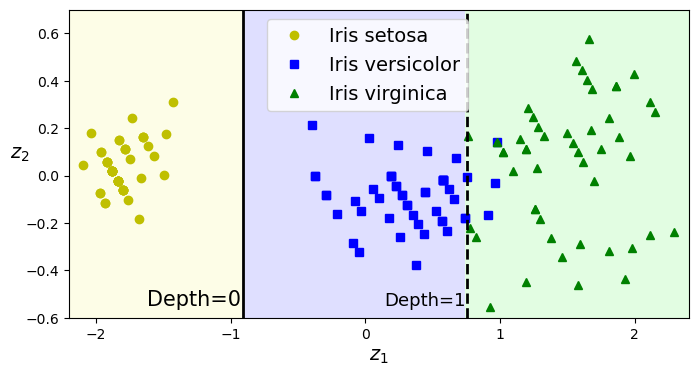

In [25]:
plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))

plt.show()

# Decision Trees Have High Variance

The main issue with decision trees is that they have quite a high _variance_. We've seen that small changes in the dataset (such as a rotation) may produce a very different Decision Tree. Changes to the hyperparameters also have a big effect.
Now let's show that training the same model on the same data may produce a very different model every time, since the CART training algorithm used by Scikit-Learn is stochastic. To show this, we will set `random_state` to a different value than earlier:

In [26]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

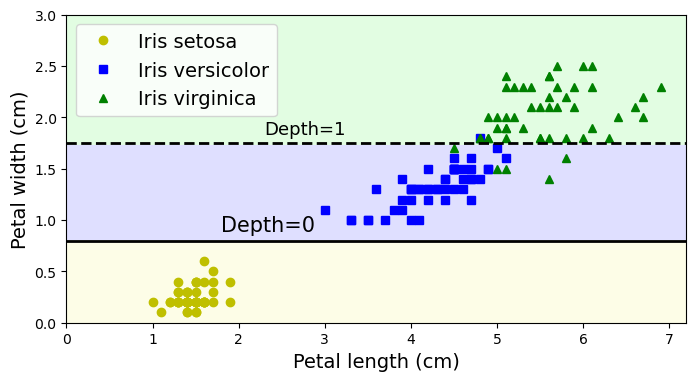

In [27]:
plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

Luckily, by averaging predictions over many trees, it's possible to reduce the variance significantly. Such an ensemble of trees is called a _random forest_ and it's one of the most powerful models available today.

# Extra: Accessing the tree structure

A trained `DecisionTreeClassifier` has a `tree_` attribute that stores the tree's structure:

In [28]:
tree = tree_clf.tree_
tree

You can get the total number of nodes in the tree:

In [29]:
tree.node_count

5

And other self-explanatory attributes are available:

In [30]:
tree.max_depth

2

In [31]:
tree.max_n_classes

3

In [32]:
tree.n_features

2

In [33]:
tree.n_outputs

1

In [34]:
tree.n_leaves

3

All the information about the nodes is stored in NumPy arrays. For example, the impurity of each node:

In [35]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

The root node is at index 0. The left and right children nodes of node _i_ are `tree.children_left[i]` and `tree.children_right[i]`. For example, the children of the root node are:

In [36]:
tree.children_left[0], tree.children_right[0]

(1, 2)

When the left and right nodes are equal, it means this is a leaf node (and the children node ids are arbitrary):

In [37]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

So you can get the leaf node ids like this:

In [38]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Non-leaf nodes are called _split nodes_. The feature they split is available via the `feature` array. Values for leaf nodes should be ignored:

In [39]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

And the corresponding thresholds are:

In [40]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

And the number of instances per class that reached each node is available too:

In [41]:
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [42]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [43]:
np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples)

True

Here's how you can compute the depth of each node:

In [44]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

Here's how to get the thresholds of all split nodes at depth 1:

In [45]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [46]:
tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]

array([1.75])

# Extra: Train and fine-tune a Decision Tree for the moons dataset

Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

Adding `random_state=42` to make this notebook's output constant:

In [47]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

Split it into a training set and a test set using `train_test_split()`.

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons,
                                                    test_size=0.2,
                                                    random_state=42)

Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [49]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              params,
                              cv=3)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [50]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=17, random_state=42)

Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

By default, `GridSearchCV` trains the best model found on the whole training set (you can change this by setting `refit=False`), so we don't need to do it again. We can simply evaluate the model's accuracy:

In [51]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8595

# Extra: Grow a Decision Forest

Continuing the previous example, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [52]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances,
                  random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [53]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8056605

Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [54]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [55]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0, keepdims=True)

Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher).

In [56]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.873

 Congratulations, you have trained a Random Forest classifier!